<a href="https://colab.research.google.com/github/g-tumwesigye/water_quality_model_assignment/blob/Jules_branch/Water_Quality_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn

In [87]:
#import data
path = "/content/water_potability.csv"
data = pd.read_csv(path)

data.head(10)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
5,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
6,10.223862,248.071735,28749.716544,7.513408,393.663396,283.651634,13.789695,84.603556,2.672989,0
7,8.635849,203.361523,13672.091764,4.563009,303.309771,474.607645,12.363817,62.798309,4.401425,0
8,NaN,118.988579,14285.583854,7.804174,268.646941,389.375566,12.706049,53.928846,3.595017,0
9,11.180284,227.231469,25484.508491,9.077200,404.041635,563.885481,17.927806,71.976601,4.370562,0


In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


## Data Preprocessing

# Handle missing values


In [89]:
data.fillna(data.mean(), inplace=True)


# Split features (X) and target (Y)


In [90]:
X = data.drop(columns=['Potability'])
Y = data['Potability']

In [91]:
# 📌 Check for class imbalance
print("Class distribution:\n", Y.value_counts())

Class distribution:
 Potability
0    1998
1    1278
Name: count, dtype: int64


# Scale features using StandardScaler


In [92]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Split data into training, validation, and test sets


In [93]:
from sklearn.model_selection import train_test_split
X_train, X_temp, Y_train, Y_temp = train_test_split(X_scaled, Y, test_size=0.30, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.50, random_state=42)


In [94]:
print(Y.value_counts())  # Check class distribution

Potability
0    1998
1    1278
Name: count, dtype: int64


In [95]:
# 📌 Compute class weights to handle imbalance
class_weights = {0: len(Y[Y == 1]) / len(Y), 1: len(Y[Y == 0]) / len(Y)}
print("Class Weights:", class_weights)

Class Weights: {0: 0.3901098901098901, 1: 0.6098901098901099}


## Model Architecture

In [96]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.regularizers import l2  # Import L2 Regularization
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

In [97]:
# Define the model
# model = Sequential([
#     Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer
#     Dropout(0.3),  # Dropout layer to prevent overfitting
#     Dense(32, activation='relu'),  # Hidden layer
#     Dropout(0.2),  # Dropout layer
#     Dense(1, activation='sigmoid')  # Output layer for binary classification
# ])

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.0005), input_shape=(X_train.shape[1],)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0005)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [98]:
# Compile the model
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# Adam optimizer with learning rate 0.001
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
# Set EarlyStopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [99]:
# Train the model
# history = model.fit(
#     X_train, Y_train,
#     class_weight=class_weights,
#     validation_data=(X_val, Y_val),
#     epochs=50,
#     batch_size=64,
#     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
#     verbose=1
# )


history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=50,
    batch_size=64,  # Increase from 32 to 64
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
    verbose=1
)


Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5519 - loss: 0.7904 - val_accuracy: 0.6212 - val_loss: 0.6878
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5776 - loss: 0.7029 - val_accuracy: 0.6314 - val_loss: 0.6782
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6208 - loss: 0.6760 - val_accuracy: 0.6375 - val_loss: 0.6738
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6357 - loss: 0.6532 - val_accuracy: 0.6436 - val_loss: 0.6663
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6540 - loss: 0.6511 - val_accuracy: 0.6517 - val_loss: 0.6570
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6576 - loss: 0.6496 - val_accuracy: 0.6578 - val_loss: 0.6464
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6595 - loss: 0.6504 - val_accuracy: 0.6721 - val_loss: 0.6407
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6809 - loss: 0.6238 - val_accuracy: 0.6721 - val_l

## **📊 Visualizations**

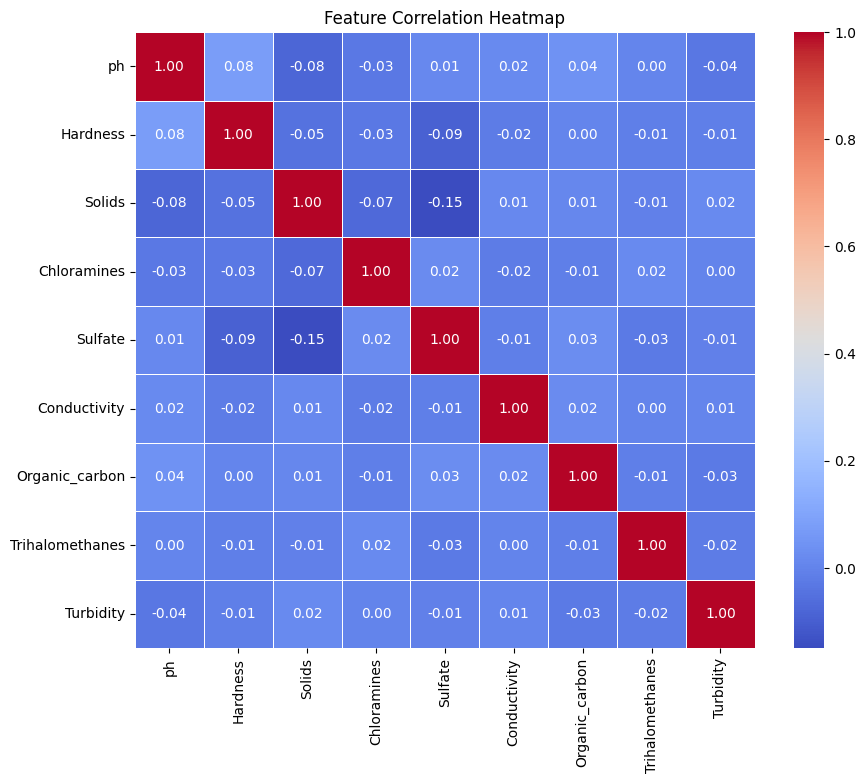

In [100]:
# Feature Correlation Heatmap

import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame(X, columns=data.drop(columns=["Potability"]).columns).corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

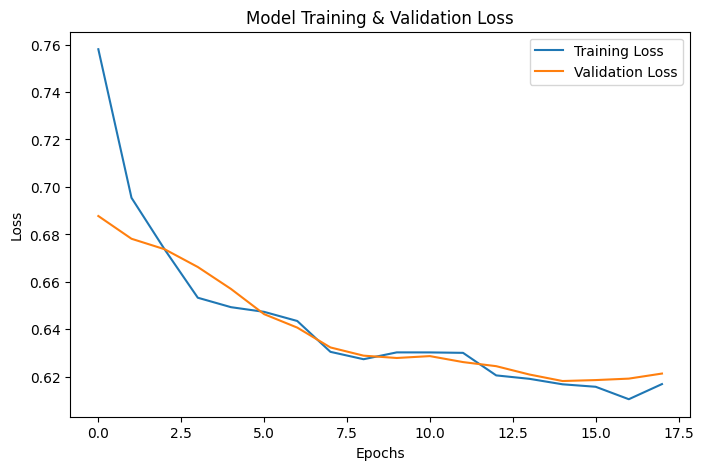

In [101]:
# Training History: Loss over Epochs
plt.figure(figsize=(8, 5))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Training & Validation Loss")
plt.legend()
plt.show()

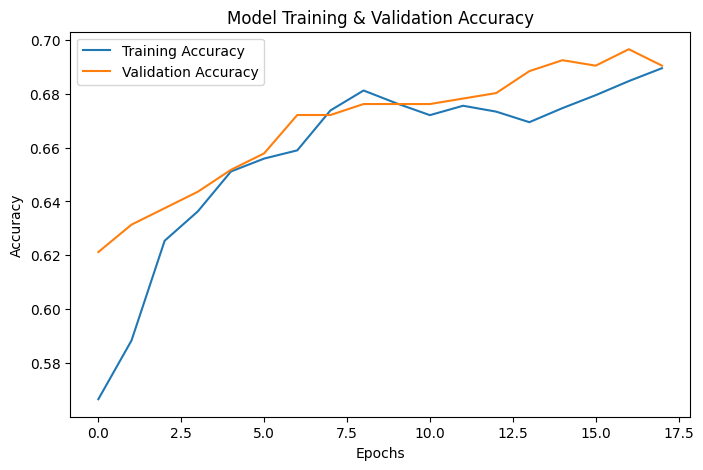

In [102]:
# Training History: Accuracy over Epochs
plt.figure(figsize=(8, 5))
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Training & Validation Accuracy")
plt.legend()
plt.show()

## Model Evaluation

In [103]:
# Evaluate on the test set
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score

# Predict on the test set
Y_pred = (model.predict(X_test) > 0.5).astype("int32")



16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


<Figure size 600x500 with 0 Axes>

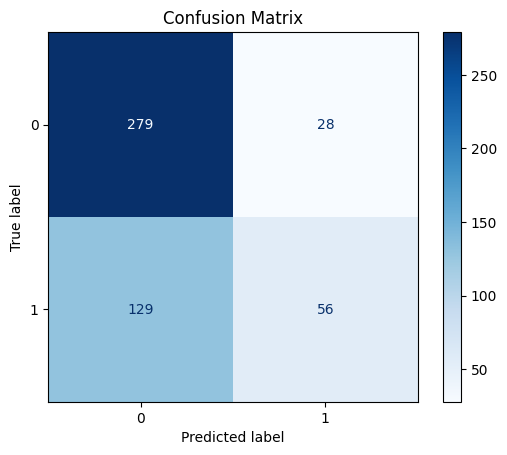

In [104]:
# Confusion Matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
disp.plot(cmap='Blues', values_format="d")
plt.title("Confusion Matrix")
plt.show()

In [105]:
# Classification Report
print("Classification Report:")
print(classification_report(Y_test, Y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.91      0.78       307
           1       0.67      0.30      0.42       185

    accuracy                           0.68       492
   macro avg       0.68      0.61      0.60       492
weighted avg       0.68      0.68      0.64       492



In [106]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6667 - loss: 0.6185 
Test Loss: 0.6180265545845032, Test Accuracy: 0.6808943152427673


In [107]:
# F1 Score, Recall, and Precision
f1 = f1_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
print(f"F1 Score: {f1}, Recall: {recall}, Precision: {precision}")

F1 Score: 0.4163568773234201, Recall: 0.3027027027027027, Precision: 0.6666666666666666


In [108]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                     │ (None, 32)                  │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,924 (7.52 KB)

 Trainable params: 929 (3.63 KB)

 Non-trainable params: 64 (256.00 B)

 Optimizer params: 931 (3.64 KB)